## Time Series regression - tune

In [1]:
# DAL Library
# version 2.1

source("../examples.R")

#loading DAL
load_dal() # see ../examples.R 

# needed for ts_arima.R
loadlibrary("elmNNRcpp")

Loading required package: dal

Warning message:
“replacing previous import ‘FNN::knn.cv’ by ‘class::knn.cv’ when loading ‘dal’”
Warning message:
“replacing previous import ‘FNN::knn’ by ‘class::knn’ when loading ‘dal’”
Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 

Warning message:
“replacing previous import ‘dplyr::combine’ by ‘randomForest::combine’ when loading ‘dal’”
Warning message:
“replacing previous import ‘Matrix::cov2cor’ by ‘stats::cov2cor’ when loading ‘dal’”
Warning message:
“replacing previous import ‘dplyr::filter’ by ‘stats::filter’ when loading ‘dal’”
Warning message:
“replacing previous import ‘dplyr::lag’ by ‘stats::lag’ when loading ‘dal’”
Warning message:
“replacing previous import ‘Matrix::toeplitz’ by ‘stats::toeplitz’ when loading ‘dal’”
Warning message:
“replacing previous import ‘Matrix::update’ by ‘stats::update’ when loading ‘dal’”

Attaching package: ‘dal’


The following object is masked from ‘package:sta

### Cosine series for studying

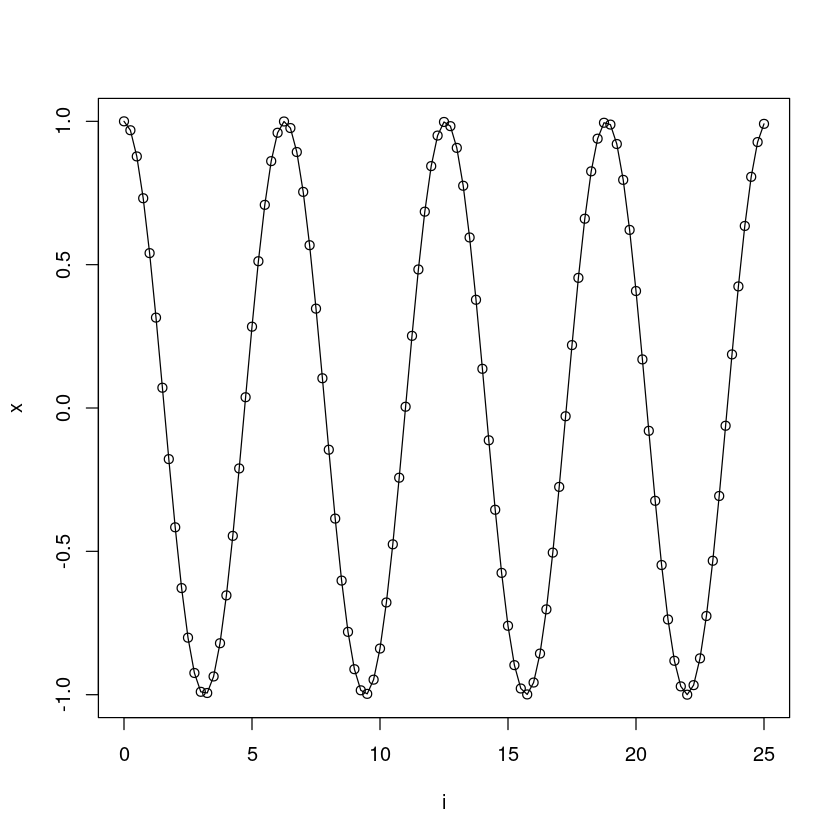

In [2]:
i <- seq(0, 25, 0.25)
x <- cos(i)

plot(i, x)
lines(i, x)

### sliding windows

In [3]:
sw_size <- 10
ts <- ts_data(x, sw_size)
head(ts, 3)

t9        t8        t7        t6        t5        t4         t3        
[1,] 1.0000000 0.9689124 0.8775826 0.7316889 0.5403023  0.3153224  0.0707372
[2,] 0.9689124 0.8775826 0.7316889 0.5403023 0.3153224  0.0707372 -0.1782461
[3,] 0.8775826 0.7316889 0.5403023 0.3153224 0.0707372 -0.1782461 -0.4161468
     t2         t1         t0        
[1,] -0.1782461 -0.4161468 -0.6281736
[2,] -0.4161468 -0.6281736 -0.8011436
[3,] -0.6281736 -0.8011436 -0.9243024

### data sampling

In [4]:
test_size <- 1
samp <- ts_sample(ts, test_size)
head(samp$train, 3)
head(samp$test)

t9        t8        t7        t6        t5        t4         t3        
[1,] 1.0000000 0.9689124 0.8775826 0.7316889 0.5403023  0.3153224  0.0707372
[2,] 0.9689124 0.8775826 0.7316889 0.5403023 0.3153224  0.0707372 -0.1782461
[3,] 0.8775826 0.7316889 0.5403023 0.3153224 0.0707372 -0.1782461 -0.4161468
     t2         t1         t0        
[1,] -0.1782461 -0.4161468 -0.6281736
[2,] -0.4161468 -0.6281736 -0.8011436
[3,] -0.6281736 -0.8011436 -0.9243024

t9         t8        t7         t6          t5        t4       t3      
[1,] -0.7256268 -0.532833 -0.3069103 -0.06190529 0.1869486 0.424179 0.635036
     t2        t1        t0       
[1,] 0.8064095 0.9276444 0.9912028

### Model training

Example is using ts_elm() as base_model, but all time series models can be used. 

Options for ranges for all time series models are presented in the end of this notebook.

Options for the list of preprocessing are presented in the end of this notebook.

Options for the list of data augmentation are presented in the end of this notebook.

Input size options should be between 1 and sw_size-2

In [5]:
tune <- ts_maintune(preprocess=list(ts_gminmax()), input_size=c(3:5), base_model = ts_elm(), augment = list(ts_augment()))
ranges <- list(nhid = 1:5, actfun=c('sig', 'radbas', 'tribas', 'relu', 'purelin'))

io_train <- ts_projection(samp$train)
model <- fit(tune, x=io_train$input, y=io_train$output, ranges)

print(describe(model))

ts_maintune-ts_elm-ts_augment,0.041



[1] "ts_elm"


### Evaluation of adjustment

In [6]:
adjust <- predict(model, io_train$input)
ev_adjust <- evaluation.tsreg(io_train$output, adjust)
print(head(ev_adjust$metrics))

           mse        smape
1 2.137759e-30 5.839794e-15


### Prediction of test

In [7]:
steps_ahead <- 1
io_test <- ts_projection(samp$test)
prediction <- predict(model, x=io_test$input, steps_ahead=steps_ahead)
prediction <- as.vector(prediction)

output <- as.vector(io_test$output)
if (steps_ahead > 1)
    output <- output[1:steps_ahead]

print(sprintf("%.2f, %.2f", output, prediction))

[1] "0.99, 0.99"


### Evaluation of test data

In [8]:
ev_test <- evaluation.tsreg(output, prediction)
print(head(ev_test$metrics))
print(sprintf("%s: smape: %.2f", describe(model), 100*ev_test$metrics$smape))

           mse        smape
1 1.036613e-29 3.248222e-15
[1] "ts_elm: smape: 0.00"


### Plot results

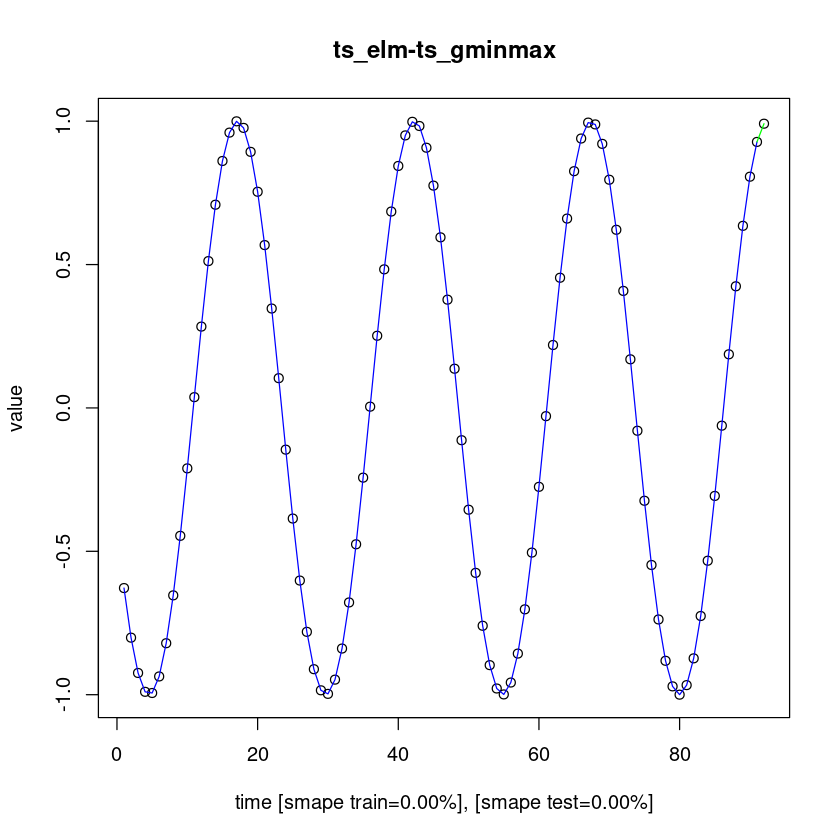

In [10]:
yvalues <- c(io_train$output, io_test$output)
tsplot(model, y=yvalues, yadj=adjust, ypre=prediction)

### Otions for machine learning

In [11]:
### Ranges for ELM
ranges_elm <- list(nhid = 1:20, actfun=c('sig', 'radbas', 'tribas', 'relu', 'purelin'))

### Ranges for MLP
ranges_mlp <- list(size = 1:10, decay = seq(0, 1, 1/9), maxit=10000)

### Ranges for RF
ranges_rf <- list(nodesize=1:10, ntree=1:10)

### Ranges for SVM
ranges_svm <- list(kernel=c("radial", "poly", "linear", "sigmoid"), epsilon=seq(0, 1, 0.1), cost=seq(20, 100, 20))

### Ranges for LSTM
ranges_lstm <- list(epochs=10000)

### Options for preprocessing

In [12]:
preprocessing <- list(ts_gminmax(), ts_diff(), ts_swminmax(), ts_an(), ts_ean())

### Options for data augmentation

In [13]:
augment <- list(ts_augment(), jitter(), stretch(), shrink(), flip(), wormhole())